In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
try:
    import torch
except ImportError:
    raise ImportError("You do not have torch installed. Run pip install torch in your terminal.")
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import expm
from collections import deque
import random
import torch.nn.functional as F

In [15]:
np.random.seed(40)
torch.manual_seed(40)

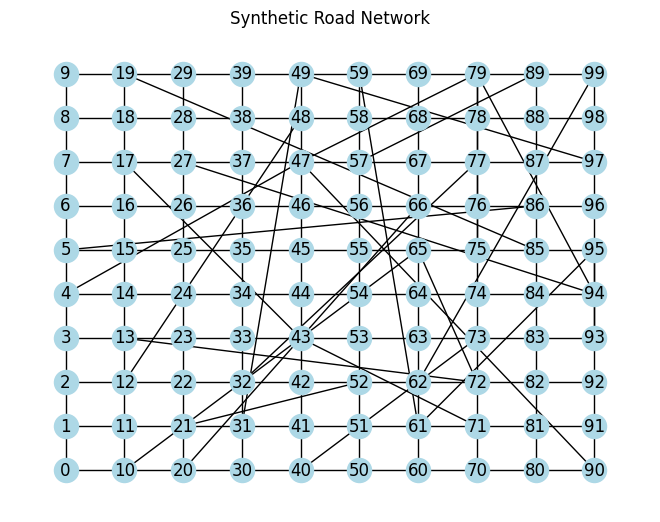

In [16]:
def create_graph(n_rows=4, n_cols=5, extra_edges=3):
    G = nx.grid_2d_graph(n_rows, n_cols)
    
    # Relabel to integer nodes
    mapping = {node: i for i, node in enumerate(G.nodes())}
    G = nx.relabel_nodes(G, mapping)
    pos = {i: node for node, i in mapping.items()}
    
    nodes = list(G.nodes())
    added = 0
    attempts = 0
    max_attempts = extra_edges * 10  # prevent infinite loop

    while added < extra_edges and attempts < max_attempts:
        u, v = np.random.choice(nodes, 2, replace=False)
        if not G.has_edge(u, v) and abs(u - v) != 1 and abs(u - v) != n_cols:
            G.add_edge(u, v)
            added += 1
        attempts += 1
    return G, pos

G, pos = create_graph(n_rows=10, n_cols=10, extra_edges=25)
num_nodes = G.number_of_nodes()
nx.draw(G, pos, with_labels=True, node_color='lightblue')
plt.title("Synthetic Road Network")
plt.show()

In [17]:
print(pos)

{0: (0, 0), 1: (0, 1), 2: (0, 2), 3: (0, 3), 4: (0, 4), 5: (0, 5), 6: (0, 6), 7: (0, 7), 8: (0, 8), 9: (0, 9), 10: (1, 0), 11: (1, 1), 12: (1, 2), 13: (1, 3), 14: (1, 4), 15: (1, 5), 16: (1, 6), 17: (1, 7), 18: (1, 8), 19: (1, 9), 20: (2, 0), 21: (2, 1), 22: (2, 2), 23: (2, 3), 24: (2, 4), 25: (2, 5), 26: (2, 6), 27: (2, 7), 28: (2, 8), 29: (2, 9), 30: (3, 0), 31: (3, 1), 32: (3, 2), 33: (3, 3), 34: (3, 4), 35: (3, 5), 36: (3, 6), 37: (3, 7), 38: (3, 8), 39: (3, 9), 40: (4, 0), 41: (4, 1), 42: (4, 2), 43: (4, 3), 44: (4, 4), 45: (4, 5), 46: (4, 6), 47: (4, 7), 48: (4, 8), 49: (4, 9), 50: (5, 0), 51: (5, 1), 52: (5, 2), 53: (5, 3), 54: (5, 4), 55: (5, 5), 56: (5, 6), 57: (5, 7), 58: (5, 8), 59: (5, 9), 60: (6, 0), 61: (6, 1), 62: (6, 2), 63: (6, 3), 64: (6, 4), 65: (6, 5), 66: (6, 6), 67: (6, 7), 68: (6, 8), 69: (6, 9), 70: (7, 0), 71: (7, 1), 72: (7, 2), 73: (7, 3), 74: (7, 4), 75: (7, 5), 76: (7, 6), 77: (7, 7), 78: (7, 8), 79: (7, 9), 80: (8, 0), 81: (8, 1), 82: (8, 2), 83: (8, 3), 8

In [18]:
class SinusoidalPosEmb(nn.Module):
    # This class was taken directly from the author's own implementation
    def __init__(self, dim, device):
        super().__init__()
        self.dim = dim
        self.device = device
        inv_freq = torch.exp(-torch.arange(0, dim, 2) * np.log(10000) / dim).to(device)
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, t):
        """
        t: Tensor of shape (batch,) - timestep values
        returns: Tensor of shape (batch, dim)
        """
        sinusoid_inp = t[:, None] * self.inv_freq[None, :]  # (B, D//2)
        emb = torch.cat([torch.sin(sinusoid_inp), torch.cos(sinusoid_inp)], dim=-1)
        return emb  # (B, D)

class GDPEmbedding(nn.Module):
    def __init__(self, num_nodes, embed_dim, device):
        super().__init__()
        self.phi = nn.Embedding(num_nodes, embed_dim)  # Learnable node embeddings 
        self.time_embedding = SinusoidalPosEmb(embed_dim, device)  # Sinusoidal timestep embedding so that the diffusion model has a sense of time

    def forward(self, node_ids, timesteps):
        """
        node_ids: Tensor of shape (batch_size, path_len), integers for each node in the path
        timesteps: Tensor of shape (batch_size,) with diffusion step index
        """
        x_embed = self.phi(node_ids)            # (B, L, D)
        t_embed = self.time_embedding(timesteps)  # (B, D)

        return x_embed, t_embed

In [21]:
# Precompute heat kernels for a range of t (e.g., t in [0.1, 0.5, 1, 2, 5])
def precompute_heat_kernels(G, t_values):
    A = nx.to_numpy_array(G)
    D = np.diag([G.degree(i) for i in range(num_nodes)])
    L = A - D
    kernels = {}
    for t in t_values:
        C = expm(t * L)
        C = C / C.sum(axis=1, keepdims=True)
        kernels[t] = C
    return kernels

t_values = [0.1, 0.5, 1, 2, 5]
heat_kernels = precompute_heat_kernels(G, t_values)

In [22]:
heat_kernels[0.1]

array([[8.26559616e-01, 7.85419609e-02, 3.85848561e-03, ...,
        6.74168523e-09, 1.11922287e-09, 5.92295434e-08],
       [7.85419609e-02, 7.51994308e-01, 7.48110095e-02, ...,
        1.64237701e-07, 3.79324040e-09, 6.01014998e-08],
       [3.85848561e-03, 7.48110095e-02, 7.51757445e-01, ...,
        2.71214629e-06, 5.74997706e-08, 1.17097886e-07],
       ...,
       [6.74168523e-09, 1.64237701e-07, 2.71214629e-06, ...,
        6.83933868e-01, 7.13156582e-02, 3.61610234e-03],
       [1.11922287e-09, 3.79324040e-09, 5.74997706e-08, ...,
        7.13156582e-02, 7.51752036e-01, 7.48045795e-02],
       [5.92295434e-08, 6.01014998e-08, 1.17097886e-07, ...,
        3.61610234e-03, 7.48045795e-02, 7.51633315e-01]])

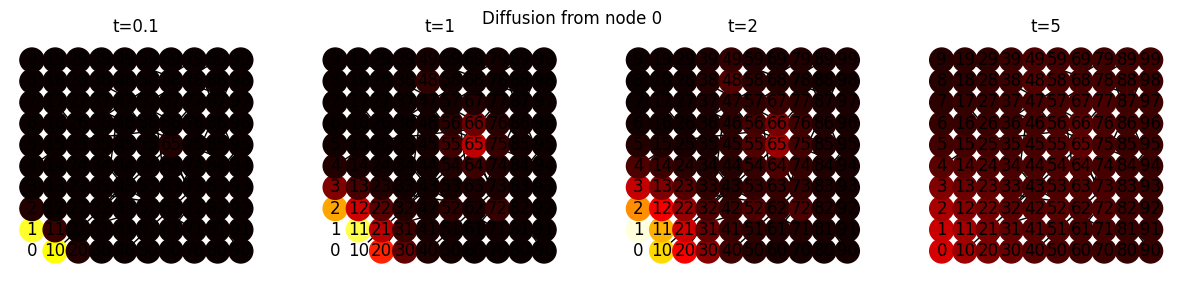

In [23]:
def plot_diffusion(node, steps=[0.1, 1, 2, 5]):
    fig, axs = plt.subplots(1, len(steps), figsize=(15, 3))
    for i, t in enumerate(steps):
        Ct = heat_kernels[t]
        p = np.zeros(num_nodes)
        p[node] = 10
        p = p @ Ct
        nx.draw(G, pos, node_color=p, cmap='hot', vmin=0, vmax=1, ax=axs[i], with_labels=True)
        axs[i].set_title(f"t={t}")
    plt.suptitle(f"Diffusion from node {node}")
    plt.show()

plot_diffusion(0)

In [24]:
def find_paths(G, num_paths=100, max_length=10):
    nodes = list(G.nodes())
    paths = []
    for _ in range(num_paths):
        while True:
            ori, dst = np.random.choice(nodes, 2, replace=False) # select any 2 nodes to be our origin and destination
            try:
                # Always start with a valid shortest path
                path = nx.shortest_path(G, ori, dst)
                # Randomly add a detour at a random position
                if len(path) > 3 and np.random.rand() < 0.3:
                    idx = np.random.randint(1, len(path)-1)
                    prev = path[idx-1]
                    curr = path[idx]
                    # Only add a neighbor of curr that is not already in the path
                    neighbors = [n for n in G.neighbors(curr) if n not in path]
                    if neighbors:
                        detour = np.random.choice(neighbors)
                        # Insert detour between curr and next, ensuring connectivity
                        path = path[:idx+1] + [detour] + path[idx+1:]
                        # Ensure the detour is connected to both curr and next
                        if not (G.has_edge(curr, detour) and G.has_edge(detour, path[idx+1])):
                            continue  # Skip if not actually connected
                # Validate path connectivity
                if 3 < len(path) <= max_length and all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1)):
                    paths.append((ori, dst, path))
                    break
            except nx.NetworkXNoPath:
                continue
    return paths

paths = find_paths(G, 1000, 30)
print(f"Generated {len(paths)} OD-path samples.")

Generated 1000 OD-path samples.


In [25]:
for ori, dst, path in paths:
    assert all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1)), f"Invalid path: {path}"

In [26]:
def diffuse_path(path, t):
    C = heat_kernels[t]
    noisy_path = []
    for node in path:
        p = np.zeros(num_nodes)
        p[node] = 1
        p = p @ C
        noisy_node = np.random.choice(num_nodes, p=p)
        noisy_path.append(noisy_node)
    return noisy_path

origin,destination,path = paths[1]
noisy_path = diffuse_path(path, t = 1.0)
print("Original:", path)
print("Noisy:", noisy_path)

Original: [23, 13, 72, 65, 55]
Noisy: [23, 14, 22, 54, 36]


## Unfinished

In [62]:
import einops
from einops.layers.torch import Rearrange
from einops import rearrange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LinearAttention(nn.Module):
    def __init__(self, dim, device, heads=4, dim_head=32):
        super().__init__()
        self.device = device
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv1d(dim, hidden_dim * 3, 1, bias=False, device=device)
        self.to_out = nn.Conv1d(hidden_dim, dim, 1, device=device)

    def forward(self, x, masks):
        # x shape is expected to be [batch_size, seq_len, embed_dim]
        batch_size, seq_len, embed_dim = x.shape
        
        # Transpose x for 1D convolution operations
        x = x.permute(0, 2, 1)  # [batch_size, embed_dim, seq_len]
        
        # Apply mask if provided
        if masks is not None:
            # Expand mask for broadcasting
            expanded_mask = masks.unsqueeze(1).expand(-1, embed_dim, -1)
            x = x.masked_fill(expanded_mask, 0)
        
        # QKV projections
        qkv = self.to_qkv(x).chunk(3, dim=1)
        
        # Reshape for multi-head attention
        # Original shape after conv: [batch, heads*dim_head, seq_len]
        # Target shape: [batch, heads, dim_head, seq_len]
        q, k, v = map(lambda t: t.reshape(batch_size, self.heads, -1, seq_len), qkv)
        
        # Apply scaling
        q = q * self.scale
        
        # Apply masks to q and k if provided
        if masks is not None:
            # Reshape mask for broadcasting with q and k
            attn_mask = masks.unsqueeze(1).unsqueeze(2).expand(-1, self.heads, 1, -1)
            q = q.masked_fill(attn_mask, 0)
            k = k.masked_fill(attn_mask, -1e15)
        
        # Compute attention weights and apply to values
        # k shape: [batch, heads, dim_head, seq_len]
        k = k.softmax(dim=-1)  # Softmax along sequence dimension
        
        # Matrix multiplication: k.transpose(-2, -1) @ v
        # [batch, heads, dim_head, seq_len] x [batch, heads, dim_head, seq_len] -> [batch, heads, dim_head, dim_head]
        context = torch.matmul(k, v.transpose(-2, -1))  # Replace einsum with matmul
        
        # Matrix multiplication: context @ q
        # [batch, heads, dim_head, dim_head] x [batch, heads, dim_head, seq_len] -> [batch, heads, dim_head, seq_len]
        out = torch.matmul(context, q)  # Replace einsum with matmul
        
        # Reshape back: [batch, heads, dim_head, seq_len] -> [batch, heads*dim_head, seq_len]
        out = out.reshape(batch_size, -1, seq_len)
        
        # Project back to original dimension
        out = self.to_out(out)
        
        # Transpose back to original shape: [batch, embed_dim, seq_len] -> [batch, seq_len, embed_dim]
        return out.permute(0, 2, 1)

In [82]:
class ReverseDiffusionModel(nn.Module):
    def __init__(self, num_nodes, embedding_dim, hidden_dim=64, n_heads=2, device='cpu'):
        super().__init__()
        self.device = device
        # Use the GDPEmbedding for node and temporal embeddings
        self.embedding = GDPEmbedding(num_nodes, embedding_dim, device)  # Using GDPEmbedding class
        self.t_embed = nn.Linear(1, hidden_dim)  # Linear transformation of time step
        self.OD_embed = nn.Linear(2 * embedding_dim, hidden_dim)  # Origin-Destination embedding
        self.spatial_fc = nn.Linear(2, hidden_dim)  # Spatial features: distance and direction
        
        # Replace MultiHeadAttention with LinearAttention for better scalability
        self.attn = LinearAttention(embedding_dim, device, heads=n_heads, dim_head=hidden_dim)
        
        # Convolutional layers for processing path representations
        self.conv1 = nn.Conv1d(embedding_dim + hidden_dim * 3, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        
        # Fully connected layer to predict logits for the nodes
        self.fc = nn.Linear(hidden_dim, num_nodes)

    def forward(self, noisy_path, t, ori, dst, masks, pos, dst_pos):
        batch_size, path_len = noisy_path.shape
        
        # Get node embeddings for the noisy path using GDPEmbedding
        node_embs, _ = self.embedding(noisy_path, t)  # Output shape: (batch_size, path_len, embedding_dim)
        
        # Apply linear attention to the node embeddings
        attn_out = self.attn(node_embs, masks)  # Output shape: (batch_size, path_len, embedding_dim)
        
        # Compute spatial features (distance and direction) for each node in the path
        spatial_feats = []
        for b in range(batch_size):
            feats = []
            for i in range(path_len):
                # Skip if mask is True (indicating padding)
                if masks[b, i]:
                    feats.append([0.0, 0.0])
                    continue
                    
                n = noisy_path[b, i].item()
                node_xy = np.array(pos[n])
                dst_xy = np.array(dst_pos[b])
                
                # Calculate distance and direction
                dist = np.linalg.norm(node_xy - dst_xy)
                direction = 0.0
                if dist > 1e-6:
                    direction = np.dot((dst_xy - node_xy), [1, 0]) / dist
                    
                feats.append([dist, direction])
            spatial_feats.append(feats)
        
        # Convert spatial features to a tensor
        spatial_feats = torch.tensor(spatial_feats, dtype=torch.float32, device=node_embs.device)
        
        # Pass spatial features through a fully connected layer
        spatial_embs = self.spatial_fc(spatial_feats)
        
        # Get the timestep embedding
        t_emb = self.t_embed(t.view(-1, 1)).unsqueeze(1).repeat(1, path_len, 1)
        
        # Get the Origin-Destination embedding
        OD_emb = self.OD_embed(torch.cat([self.embedding.phi(ori), self.embedding.phi(dst)], dim=-1)).unsqueeze(1).repeat(1, path_len, 1)
        
        # Concatenate all embeddings
        x = torch.cat([attn_out, t_emb, OD_emb, spatial_embs], dim=-1)
        
        # Permute for convolution
        x = x.permute(0, 2, 1)  # [batch_size, channels, seq_len]
        
        # Apply convolution layers
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Permute back
        x = x.permute(0, 2, 1)  # [batch_size, seq_len, channels]
        
        # Final projection to get logits
        logits = self.fc(x)
        
        return logits

In [83]:
from torch.utils.data import DataLoader
# Assuming `t_values`, `pos`, `paths`, and `num_nodes` are defined as per your environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_dim = 16  

def prepare_batch(paths, pos, batch_size=16):
    batch = random.sample(paths, batch_size)
    max_len = max(len(p[2]) for p in batch)
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = [], [], [], [], [], [], []
    
    for ori, dst, path in batch:
        t = np.random.choice(t_values)  # Random timestep
        noisy = diffuse_path(path, t)  # Diffuse the path
        
        path_len = len(path)
        pad_len = max_len - path_len
        
        # Pad paths with zeros
        noisy_padded = noisy + [0] * pad_len
        path_padded = path + [0] * pad_len
        
        # Create mask: False (0) for valid positions, True (1) for padding positions
        mask = [False] * path_len + [True] * pad_len
        
        # Enforce O/D at endpoints
        noisy_padded[0] = ori
        noisy_padded[path_len-1] = dst
        path_padded[0] = ori
        path_padded[path_len-1] = dst
        
        # Do not compute loss for origin and destination
        mask[0] = True  # Mask loss for origin
        mask[path_len-1] = True  # Mask loss for destination
        
        noisy_paths.append(noisy_padded)
        clean_paths.append(path_padded)
        oris.append(ori)
        dsts.append(dst)
        ts.append(t)
        masks.append(mask)
        dst_pos.append(pos[dst])
    
    return (torch.LongTensor(noisy_paths).to(device),
            torch.LongTensor(clean_paths).to(device),
            torch.LongTensor(oris).to(device),
            torch.LongTensor(dsts).to(device),
            torch.FloatTensor(ts).to(device),
            torch.BoolTensor(masks).to(device),  # Using BoolTensor for clarity
            dst_pos)

# Create your ReverseDiffusionModel instance
model = ReverseDiffusionModel(num_nodes, embedding_dim, device=device)

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss functions (KL divergence, cross-entropy, and contribution loss)
def compute_loss(logits, clean_paths, masks, adjacency_matrix):
    """
    Compute KL divergence loss, cross-entropy loss, and contribution loss.
    """
    batch_size, seq_len = logits.shape[0], logits.shape[1]
    
    # Cross-entropy loss (masked)
    clean_paths = clean_paths.view(-1)
    masks_flat = masks.view(-1)
    logits_flat = logits.view(-1, num_nodes)
    
    ce_loss = nn.CrossEntropyLoss()(logits_flat[masks_flat], clean_paths[masks_flat])
    
    # Contribution loss (penalize invalid transitions according to the adjacency matrix)
    eps = 1e-6  # Small epsilon to avoid numerical issues
    node_probs = torch.softmax(logits_flat, dim=-1)
    
    # Check if adjacency_matrix is a dict and convert it to a tensor if needed
    if isinstance(adjacency_matrix, dict):
        # Create a tensor from the adjacency matrix dictionary
        # This is an example approach - you might need to adjust based on your specific dict structure
        adj_tensor = torch.zeros_like(node_probs)
        
        # Populate the adjacency tensor based on your dictionary structure
        # Example (adjust according to your actual dictionary structure):
        for i in range(adj_tensor.shape[0]):
            for j in range(adj_tensor.shape[1]):
                node_id = i % num_nodes  # Get the node ID
                if node_id in adjacency_matrix:
                    # Assuming adjacency_matrix[node_id] contains valid transitions
                    if j in adjacency_matrix[node_id]:
                        adj_tensor[i, j] = 1.0
                        
        # Use the tensor for the calculation
        con_loss = -torch.sum(torch.log(node_probs + eps) * adj_tensor) / batch_size
    else:
        # Assuming adjacency_matrix is already a tensor with the right shape
        con_loss = -torch.sum(torch.log(node_probs + eps) * adjacency_matrix) / batch_size
    
    # Return total loss
    return ce_loss + con_loss

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    
    # Prepare batch
    noisy_paths, clean_paths, oris, dsts, ts, masks, dst_pos = prepare_batch(paths, pos, batch_size=32)
    
    # Forward pass through the model
    logits = model(noisy_paths, ts, oris, dsts, masks, pos, dst_pos)
    
    # Compute loss (using KL divergence, cross-entropy, and contribution loss)
    loss = compute_loss(logits, clean_paths, masks, adjacency_matrix=pos)
    
    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 65.5575
Epoch 5, Loss: 53.5128
Epoch 10, Loss: 43.3923
Epoch 15, Loss: 39.9892
Epoch 20, Loss: 39.0109
Epoch 25, Loss: 37.4931
Epoch 30, Loss: 37.4669
Epoch 35, Loss: 36.6515
Epoch 40, Loss: 40.6714
Epoch 45, Loss: 36.2140
Epoch 50, Loss: 36.2116
Epoch 55, Loss: 36.1097
Epoch 60, Loss: 39.7552
Epoch 65, Loss: 36.0146
Epoch 70, Loss: 35.7173
Epoch 75, Loss: 39.4946
Epoch 80, Loss: 35.9317
Epoch 85, Loss: 35.6325
Epoch 90, Loss: 35.4624
Epoch 95, Loss: 39.7561
Epoch 100, Loss: 35.7938
Epoch 105, Loss: 35.3733
Epoch 110, Loss: 35.5919
Epoch 115, Loss: 35.5418
Epoch 120, Loss: 35.8322
Epoch 125, Loss: 35.8244
Epoch 130, Loss: 35.7083
Epoch 135, Loss: 39.2549
Epoch 140, Loss: 35.8842
Epoch 145, Loss: 35.6323
Epoch 150, Loss: 35.6586
Epoch 155, Loss: 35.3680
Epoch 160, Loss: 35.7490
Epoch 165, Loss: 35.4178
Epoch 170, Loss: 35.3385
Epoch 175, Loss: 35.3886
Epoch 180, Loss: 35.1139
Epoch 185, Loss: 39.4208
Epoch 190, Loss: 35.1732
Epoch 195, Loss: 35.6800
Epoch 200, Loss: 35.42

In [84]:
def beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20, t=1.0):
    model.eval()
    beams = [([ori], 0.0)]  # Each beam is (path, cumulative_log_prob)
    dst_pos = [pos[dst]]
    
    for step in range(max_len - 1):
        new_beams = []
        for path, log_prob in beams:
            current = path[-1]
            
            # Only allow neighbors (and destination if it's a neighbor)
            neighbors = list(G.neighbors(current))
            if dst not in neighbors and current != dst:
                candidates = neighbors
            else:
                candidates = neighbors + ([dst] if dst in neighbors else [])
            
            if not candidates:
                continue  # Dead end
                
            # Diffuse the path for the noisy version with reduced noise
            noisy_path = diffuse_path(path, t=0.5)  # Smaller value for t reduces noise
            pad_len = max_len - len(noisy_path)
            noisy_path_tensor = torch.LongTensor([noisy_path + [0] * pad_len]).to(model.device)
            
            # Create the mask for valid positions (1 for valid node, 0 for padding)
            mask = torch.BoolTensor([[True] * len(noisy_path) + [False] * pad_len]).to(model.device)
            
            # Prepare the other necessary inputs
            ori_tensor = torch.LongTensor([ori]).to(model.device)
            dst_tensor = torch.LongTensor([dst]).to(model.device)
            t_tensor = torch.FloatTensor([t]).to(model.device)
            
            with torch.no_grad():
                # Perform the forward pass of the model
                logits = model(noisy_path_tensor, t_tensor, ori_tensor, dst_tensor, mask, pos, dst_pos)
                
                # Extract the logits for the current step (corresponding to the last node in the path)
                current_step_logit = logits[0, len(path) - 1]
                
                # Convert logits to probabilities using softmax
                probs = torch.softmax(current_step_logit, dim=-1).cpu().numpy()
            
            # Only consider valid next nodes (candidates)
            for n in candidates:
                prob = probs[n]
                if prob > 0:  # Consider only non-zero probability nodes
                    new_path = path + [n]
                    
                    # Ensure no excessive repetition of nodes in the path
                    if new_path.count(n) >= 3:  # Skip paths with too many repetitions
                        continue
                    
                    new_log_prob = log_prob + np.log(prob)
                    new_beams.append((new_path, new_log_prob))
        
        # Prune to top beam_width beams by cumulative log probability
        new_beams = sorted(new_beams, key=lambda x: -x[1])[:beam_width]
        beams = new_beams
        
        # If any beam ends at dst, return the first such path
        for path, _ in beams:
            if path[-1] == dst:
                return path
        
        if not beams:
            break  # No valid extensions
        
    # If no path reaches dst, return the best partial beam
    return beams[0][0] if beams else [ori]

Planned path: [60, 70, 80, 70, 60, 50, 40, 41, 40, 41, 42, 32, 42, 52, 53]


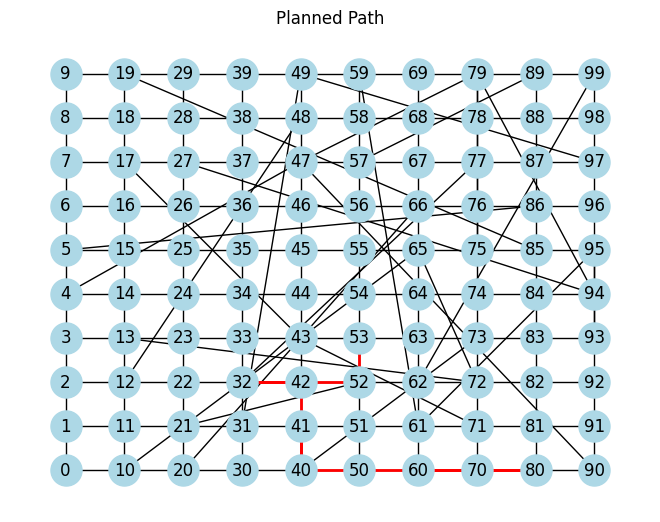

In [85]:
# Example: Plan a path from ori to dst
ori, dst, _ = random.choice(paths)
planned_path = beam_search_path(model, G, ori, dst, pos, beam_width=5, max_len=20)
print("Planned path:", planned_path)

# Visualize the path on the graph
def plot_path(G, pos, path, color='r', label='Planned'):
    # Draw the graph with node labels and positions
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=12)
    
    # Create edges from the planned path
    edges = list(zip(path[:-1], path[1:]))  # Create a list of edges from the path
    
    # Draw the edges of the path in the specified color
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, width=2, label=label)
    
    # Display the plot with a title
    plt.title(label)
    plt.show()

# Call plot_path to visualize the planned path
plot_path(G, pos, planned_path, color='r', label='Planned Path')

In [86]:
from difflib import SequenceMatcher
import numpy as np
import random

def lcs(a, b):
    # Find the longest common subsequence between two paths
    matcher = SequenceMatcher(None, a, b)
    return matcher.find_longest_match(0, len(a), 0, len(b)).size

def dtw(a, b):
    # Calculate Dynamic Time Warping distance between two paths
    n, m = len(a), len(b)
    dp = np.full((n+1, m+1), float('inf'))
    dp[0, 0] = 0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = 0 if a[i-1] == b[j-1] else 1
            dp[i, j] = cost + min(dp[i-1, j], dp[i, j-1], dp[i-1, j-1])
    return dp[n, m]

def is_valid_path(G, path):
    # Check if the path is valid in the graph (all consecutive edges must exist)
    return all(G.has_edge(path[i], path[i+1]) for i in range(len(path)-1))

hits = []
lcs_scores = []
dtw_scores = []

# Evaluate the model on 20 randomly selected paths
for i in range(20):
    ori, dst, gt_path = random.choice(paths)
    
    # Plan the path using beam search
    pred_path = beam_search_path(model, G, ori, dst, pos, beam_width=50, max_len=30)
    
    # Skip evaluation if the predicted path is invalid
    if not is_valid_path(G, pred_path):
        hits.append(False)  # Invalid paths should not be counted in hits
        continue

    # Compute the hit ratio (1 if destination is the last node, otherwise 0)
    hit = (pred_path[-1] == dst)
    hits.append(hit)

    # Compute LCS and DTW between the ground truth and predicted paths (ignoring padding)
    lcs_scores.append(lcs(gt_path, pred_path))
    dtw_scores.append(dtw(gt_path, pred_path))

# Compute and print the average metrics
print(f"Hit ratio: {np.mean(hits):.2f}, Avg LCS: {np.mean(lcs_scores):.2f}, Avg DTW: {np.mean(dtw_scores):.2f}")


Hit ratio: 0.75, Avg LCS: 2.10, Avg DTW: 15.30
